<a href="https://colab.research.google.com/github/Diz138/YelpReviews/blob/main/Merged_MTL_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
import nltk
from collections import Counter
import string
import re
import math
import seaborn as sns
import tensorflow as tf
from nltk import word_tokenize
nltk.download('stopwords')
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from keras.callbacks import EarlyStopping
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
#df = pd.read_pickle("/content/drive/MyDrive/CS525/yelp_compressed_reviews.pkl")
#df = pd.read_pickle("/content/drive/MyDrive/yelp_food_reviews.pkl")
df = pd.read_pickle("/content/drive/MyDrive/CS525/yelp_compressed_reviews2.pkl")
df.head()


,business_id,stars,review_count,visits,visits_normalized,label,reviews_concatenated
0,MTSW4McQd7CbVtyjqoe9mw,4.0,80,335,27.916667,1,This is nice little Chinese bakery in the hear...
1,0bPLkL0QhhPO5kt1_EXmNQ,4.5,100,264,22.000000,1,The worst Chicken Parm. Sandwich I've ever eat...
2,MUTTqe8uqyMdBl186RmNeA,4.0,245,172,34.400000,1,Stopped in to check out this new spot around t...
3,ROeacJQwBeh05Rqg7F6TCg,4.5,205,221,24.555556,1,"This place is fantastic! Delicious, simple, h..."
4,9OG5YkX1g2GReZM0AskizA,2.5,339,508,42.333333,1,Great bar Happy Hour 4-7 every day. Wine & Dra...


Functions to modify ratings --> sentiment for sentiment analysis and popularity to format acceptable to keras

In [ ]:
import tensorflow as tf
def sentiment(val):
  if val >= 3:
    return 1
  else:
    return 0
def popularity(val):
  if val == 0.0:
    return tf.convert_to_tensor([1,0,0,0,0])
  elif val == 1.0:
    return tf.convert_to_tensor([0,1,0,0,0])
  elif val == 2.0:
    return tf.convert_to_tensor([0,0,1,0,0])
  elif val == 3.0:
    return tf.convert_to_tensor([0,0,0,1,0])
  else:
    return tf.convert_to_tensor([0,0,0,0,1])

In [ ]:
#subset = df[['text','label','stars']].sample(n=100000, random_state=8)
#subset = df[['reviews_concatenated','label','stars']].sample(n=100000, random_state=8)
subset = df[['reviews_concatenated','label','stars']]
subset['sent'] = subset['stars'].apply(lambda x: sentiment(x))
subset['stars'] = subset['stars'].apply(
    lambda x: math.floor(x)
)
#subset['label'] = subset['label'].apply(lambda x: popularity(x))
subset.head(20)

<ipython-input-21-c80523b4129e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['sent'] = subset['stars'].apply(lambda x: sentiment(x))
<ipython-input-21-c80523b4129e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['stars'] = subset['stars'].apply(


,reviews_concatenated,label,stars,sent
0,This is nice little Chinese bakery in the hear...,1,4,1
1,The worst Chicken Parm. Sandwich I've ever eat...,1,4,1
2,Stopped in to check out this new spot around t...,1,4,1
3,"This place is fantastic! Delicious, simple, h...",1,4,1
4,Great bar Happy Hour 4-7 every day. Wine & Dra...,1,2,0
5,cute ambience that would be great for date nig...,1,4,1
6,"This place is top notch, with phenomenal servi...",0,4,1
7,Bunch of high school/college kids running the ...,0,3,1
8,This is a great place to take guests visiting ...,1,3,1
9,"We had been driving around for some time, on a...",0,3,1


In [ ]:
subset = subset.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
subset['reviews_concatenated'] = subset['reviews_concatenated'].apply(clean_text)

In [ ]:
subset

,reviews_concatenated,label,stars,sent
0,nice little chinese bakery heart philadelphias...,1,4,1
1,worst chicken parm sandwich ive ever eaten chi...,1,4,1
2,stopped check new spot around corner us boyfri...,1,4,1
3,place fantastic delicious simple healthy liter...,1,4,1
4,great bar happy hour 47 every day wine drafts ...,1,2,0
...,...,...,...,...
22362,still fan tried place give fair shake disappoi...,0,2,0
22363,youre looking good hoagie go wawa people got o...,0,3,1
22364,happy hour bar amazing 3 wine beer champagne d...,1,4,1
22365,ended leavingwe made reservation 2 715 29th ar...,1,4,1


In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(subset['reviews_concatenated'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1242595 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(subset['reviews_concatenated'].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (22367, 250)


In [ ]:
Y = subset[['label','stars','sent']]
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (22367, 3)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(20130, 250) (20130, 3)
(2237, 250) (2237, 3)


Separating each of the outputs into their own variables to pass into Keras

In [ ]:
Y_train_pop = pd.get_dummies(Y_train['label']).values
Y_train_stars = pd.get_dummies(Y_train['stars']).values
Y_train_sent = pd.get_dummies(Y_train['sent']).values
Y_test_pop = pd.get_dummies(Y_test['label']).values
Y_test_stars = pd.get_dummies(Y_test['stars']).values
Y_test_sent = pd.get_dummies(Y_test['sent']).values

In [ ]:
Y_train_pop

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]], dtype=uint8)

Model Creation

In [ ]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten

from keras.utils import plot_model
dr = 0.3

inputs = Input(shape=X.shape[1], name='main_input')

main_branch = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])(inputs)
main_branch = SpatialDropout1D(0.2)(main_branch)
main_branch = LSTM(100, dropout=0.2, recurrent_dropout=0.2)(main_branch)

In [ ]:
popularity_branch = Dense(5, activation='softmax', name='popularity_output')(main_branch)
sentiment_branch = Dense(2, activation='sigmoid', name='sentiment_output')(main_branch)
stars_branch = Dense(5, activation='softmax', name='stars_output')(main_branch)

In [ ]:
model = Model(inputs = inputs,
     outputs = [popularity_branch, sentiment_branch,stars_branch])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 250)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 250, 100)     5000000     ['main_input[0][0]']             
                                                                                                  
 spatial_dropout1d_1 (SpatialDr  (None, 250, 100)    0           ['embedding_1[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 lstm_1 (LSTM)                  (None, 100)          80400       ['spatial_dropout1d_1[0][0]

In [ ]:
opt = keras.optimizers.RMSprop(lr=1e-3)
model.compile(optimizer='adam',
              loss={'popularity_output': 'categorical_crossentropy', 'sentiment_output': 'binary_crossentropy','stars_output': 'categorical_crossentropy',},
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 250)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 250, 100)     5000000     ['main_input[0][0]']             
                                                                                                  
 spatial_dropout1d_1 (SpatialDr  (None, 250, 100)    0           ['embedding_1[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 lstm_1 (LSTM)                  (None, 100)          80400       ['spatial_dropout1d_1[0][0]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
from keras.utils import plot_model
model.fit({'main_input': X_train},
              {'popularity_output': Y_train_pop, 'sentiment_output': Y_train_sent,'stars_output': Y_train_stars},
              epochs=10, batch_size=128,
              verbose=1,
              #callbacks=[plot_progress],
              validation_split=0.2,
             )

Epoch 1/10
126/126 [==============================] - 132s 1s/step - loss: 2.4381 - popularity_output_loss: 1.0921 - sentiment_output_loss: 0.3071 - stars_output_loss: 1.0389 - popularity_output_accuracy: 0.4781 - sentiment_output_accuracy: 0.9183 - stars_output_accuracy: 0.5415 - val_loss: 2.2749 - val_popularity_output_loss: 1.0272 - val_sentiment_output_loss: 0.2685 - val_stars_output_loss: 0.9792 - val_popularity_output_accuracy: 0.4896 - val_sentiment_output_accuracy: 0.9240 - val_stars_output_accuracy: 0.5504
Epoch 2/10
126/126 [==============================] - 127s 1s/step - loss: 2.2568 - popularity_output_loss: 1.0334 - sentiment_output_loss: 0.2642 - stars_output_loss: 0.9592 - popularity_output_accuracy: 0.4955 - sentiment_output_accuracy: 0.9235 - stars_output_accuracy: 0.5639 - val_loss: 2.3710 - val_popularity_output_loss: 1.0329 - val_sentiment_output_loss: 0.2751 - val_stars_output_loss: 1.0629 - val_popularity_output_accuracy: 0.4898 - val_sentiment_output_accuracy: 0

In [ ]:
model.save("my_model")

In [ ]:
reconstructed_model = keras.models.load_model("my_model")

In [ ]:
accr = model.evaluate(X_test,[Y_test[:,0],Y_test[:,1]])
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}\n  Accuracy2: {:0.3f}'.format(accr[0],accr[1],accr[2]))

TypeError: ignored

In [ ]:
plt.title('Loss')
plt.plot(reconstructed_model.history['loss'], label='train')
plt.plot(reconstructed_model.history['val_loss'], label='test')
plt.legend()
plt.show();


In [ ]:
plt.title('Accuracy')
plt.plot(model.history['accuracy'], label='train')
plt.plot(model.history['val_accuracy'], label='test')
plt.legend()
plt.show();


In [ ]:
predicted = model.predict(X_test)

70/70 [==============================] - 5s 68ms/step


In [ ]:
predicted_pop = predicted[0]
predicted_sent = predicted[1]
predicted_stars = predicted[2]

In [ ]:
predicted_pop = np.argmax(predicted_pop,axis =1)
predicted_sent = np.argmax(predicted_sent,axis =1)
predicted_stars = np.argmax(predicted_stars,axis =1)

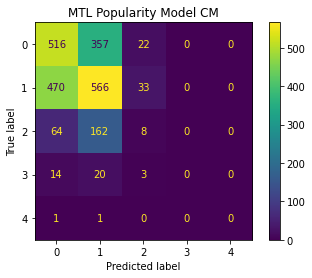

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(Y_test.iloc[:,0].values,predicted_pop)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=[0,1,2,3,4])

cm_display.plot()
plt.title("MTL Popularity Model CM")
plt.show()

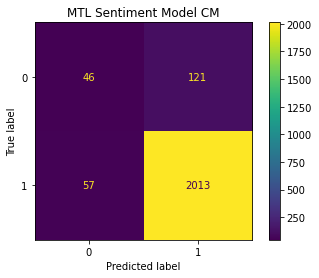

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(Y_test.iloc[:,2].values,predicted_sent)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=[0,1])

cm_display.plot()
plt.title("MTL Sentiment Model CM")
plt.show()

In [ ]:
new_pred_stars = predicted_stars + 1

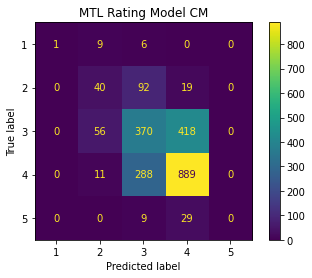

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(Y_test.iloc[:,1].values,new_pred_stars)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=[1,2,3,4,5])

cm_display.plot()
plt.title("MTL Rating Model CM")
plt.show()

In [ ]:
Y_test.iloc[:,1].unique()

In [ ]:
predicted_stars

In [ ]:
new_pred_stars